In [23]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import scipy.interpolate as inter
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.optimize import minimize

import ctypes
from numpy.ctypeslib import ndpointer

In [3]:
# ALL DEFINITIONS

def vertical_len(single_freq_iono, y):
    inc = 0;
    while single_freq_iono[y + inc] > 1 and (y + inc) < len(single_freq_iono):
        inc += 1;
    return inc

def neighbor_len(single_freq_iono, y):
    inc = 0;
    while single_freq_iono[y - inc] > 1 and (y - inc) > 0:
        inc += 1;
    total = inc + vertical_len(single_freq_iono, y)
    if (total > 1):
        total -=1
    return total

def shrink(data_array_1):
    y_dim, x_dim = data_array_1.shape
    data_array = data_array_1.copy()
    for i in range(0, x_dim):
        single_freq_iono = data_array[:, i]
        for j in range(0, y_dim - 2):
            if (single_freq_iono[j] > 1 and single_freq_iono[j + 1] > 1):
                if i != x_dim - 1:
                    neighbor_len_right = neighbor_len(data_array[:, i + 1], j)
                    print(neighbor_len_right)
                    if (neighbor_len_right >= 2):
                        inc = vertical_len(single_freq_iono, j)
                        print(inc)
                        for k in range(j, j + inc):
                            if k != (np.floor((j + j + inc)/2)):
                                print(k)
                                single_freq_iono[k] = 0
                                print(single_freq_iono)
        data_array[:, i] = single_freq_iono
    return data_array

def neighbor_exist(single_freq_iono, y):
    if ((y - 1) > 0 and (single_freq_iono[y] and single_freq_iono[y - 1])) or ((y + 1) < len(single_freq_iono) and (single_freq_iono[y] and single_freq_iono[y + 1])):
        return 1
    return 0

def neighbor_check(data_array_1):
    y_dim, x_dim = data_array_1.shape
    data_array = data_array_1.copy()
    for i in range(1, y_dim - 1):
        for j in range(1, x_dim - 1):
            if not (data_array[i - 1, j - 1] or data_array[i - 1, j] or data_array[i - 1, j + 1] 
                    or data_array[i, j - 1] or data_array[i, j + 1]
                    or data_array[i + 1, j - 1] or data_array[i + 1, j] or data_array[i + 1, j + 1]):
                    data_array[i, j] = 0
    return data_array

def find_min_xy(arr2d):
    # This function finds the minimun x and y coordinates of a cluster
    min_x = np.inf
    min_y = np.inf
    for i in range(0, len(arr2d)):
        if arr2d[i, 0] < min_x:
            min_x = arr2d[i, 0]
        if arr2d[i, 1] < min_y:
            min_y = arr2d[i, 1]
    return min_x, min_y

def find_max_xy(arr2d):
    # This function finds the maximun x and y coordinates of a cluster
    max_x = 0
    max_y = 0
    for i in range(0, len(arr2d)):
        if arr2d[i, 0] > max_x:
            max_x = arr2d[i, 0]
        if arr2d[i, 1] > max_y:
            max_y = arr2d[i, 1]
    return max_x, max_y

def find_max_area(arr2d):
    # This function finds the maximun area using min and max coords.
    return (find_max_xy(arr2d)[0] - find_min_xy(arr2d)[0])*(find_max_xy(arr2d)[1] - find_min_xy(arr2d)[1])

def group_labels(X_image, labels, n_clusters):
    # This function groups every cluster together.
    # Input X_image is a 2d array that are coordinate pairs;
    # Input labels are a 1d array specify the cluster label for each coordinate pairs.
    # Output group is a dictionary that has the format: {label: list of pairs}
    current_label = 0;
    group = {};
    for i in range(0, n_clusters ):
        group[i] = []

    for j in range(0, len(labels)):
        group[labels[j]].append(X_image[j])
    return group

def find_cluster(X_image, labels, n_clusters):
    group = group_labels(X_image, labels, n_clusters)
    group_want = 0
    max_area = 0
    for i in range(0, n_clusters):
        if find_max_area(np.array(group[i])) > max_area:
            max_area = find_max_area(np.array(group[i]))
            group_want = i
    return group_want

def coor_pair_to_mesh_array(arr2d):
    max_x, max_y = find_max_xy(arr2d)
    mesh_array = np.zeros(np.array([max_y + 1, max_x + 1]).astype(int))
    for i in range(0, len(arr2d)):
        coord = arr2d[i].astype(int)
        mesh_array[coord[1], coord[0]] = 10
    return mesh_array

def avg_y(arr2d):
    return np.mean(arr2d[:, 1])

def max_num_group_and_len(sub_cluster):
    current_len = 0
    current_group = 0
    for i in range(0, len(sub_cluster)):
        if len(sub_cluster[i]) > current_len:
            current_len = len(sub_cluster[i])
            current_group = i
    return current_group, current_len

def find_nearst_cluster(predicted, sub_cluster_avg):
    modified = abs(np.array(sub_cluster_avg) - predicted)
    compare = np.inf
    ind = -1
    for i in range(0, len(modified)):
        if modified[i] < 40 and modified[i] < compare:
            compare = modified[i]
            ind = i
    if ind == -1:
        return ind
    return ind, sub_cluster_avg[ind]

def vertical_noise_substraction(data):
    #data_new = np.log10(data)
    data_new = data.copy()
    data_new[0:7, :] = 0
    data_new[:, 0:150] = 0
    data_new[:, -30:-1] = 0
    for trial in range(0, 3):
        for j in range(0, len(freqs)):
            single_freq_iono = np.array(data_new[:,j])
            avg_power = single_freq_iono.sum()*1.0/(len(single_freq_iono))
            noise_sum = 0
            max_power = np.max(single_freq_iono)
            median_power = np.median(single_freq_iono)
            #'''
            for i in range(0, len(single_freq_iono)):
                if (single_freq_iono[i] < 0.5*max_power):
                    noise_sum += single_freq_iono[i]
            noise = noise_sum/len(single_freq_iono)
            for i in range(0, len(single_freq_iono)):
                if (single_freq_iono[i] - noise < 1):
                    single_freq_iono[i] = 1
                else:
                    single_freq_iono[i] = single_freq_iono[i] - noise

            data_new[:,j] = single_freq_iono*1
    return data_new

# find nnz in an array
def find_nnz(data):
    nnz = 0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i, j] != 0:
                nnz += 1
    return nnz

def mean_clear(data_after_substraction):
    data_processed = data_after_substraction.copy()
    nnz = find_nnz(data_processed)
    array_mean = np.sum(data_processed)/nnz
    for i in range(data_processed.shape[0]):
        for j in range(data_processed.shape[1]):
            if data_processed[i, j] > array_mean*0.85:
                data_processed[i, j] = 10
            else:
                data_processed[i, j] = 0
    return data_processed

def whole_clean_procedure():
    # whole procedure, below this cell is individual step
    iono_num = 0

    data_processed = mean_clear(vertical_noise_substraction(ionograms[iono_num,:,:]))
    nnz = find_nnz(data_processed)
    x_image = np.zeros(nnz)
    y_image = np.zeros(nnz)
    ind = 0
    for i in range(data_processed.shape[0]):
        for j in range(data_processed.shape[1]):
            if data_processed[i, j] > 1:
                x_image[ind] = i;
                y_image[ind] = j;
                ind += 1

    X_image = np.concatenate((np.array([y_image]), np.array([x_image])))
    X_image = X_image.T

    n_clusters = 75
    plt.figure(figsize=(20, 10))
    model = AgglomerativeClustering(linkage="single",
                                    connectivity=None,
                                    n_clusters=n_clusters)
    model.fit(X_image)

    group_want = find_cluster(X_image, model.labels_, n_clusters)
    X_image_want = np.array(group_labels(X_image, model.labels_, n_clusters)[group_want])

    x_group = X_image_want[:, 0]
    y_group = X_image_want[:, 1]

    data_final = np.zeros(data_processed.shape)
    for i in range(0, len(X_image_want)):
        row = int(X_image_want[i, 0]);
        col = int(X_image_want[i, 1]);
        data_final[col, row] = 10
    
    return data_final

#     fig = figure(figsize=(14, 7))
#     im = pcolormesh(freqs,hts,data_final)
#     im.set_clim(0.2,9.8)
#     im.axes.set_xlim(2,12); im.axes.set_ylim(50,750); 
#     im.axes.set_title(filename + "_cleaned")
    
#     # show and save
#     #show(im)
#     fig.savefig(folderout+'/'+filename[6:6+13]+'_OXgrams.png')   # png format
#     clf()
    


def mapping_f(fvsO):
    return (408*(fvsO)/(12.18267773-1.601)).astype(int)

def mapping_hv(vhsO):
    return (512*(vhsO)/800).astype(int)

def coor_pair_to_mesh_array_whole(arr2d, dim):
    mesh_array = np.zeros(dim)
    for i in range(0, len(arr2d)):
        coord = arr2d[i].astype(int)
        coord1 = coord[1]
        coord0 = coord[0]
        if coord1 < dim[0] and coord1 > 0 and coord0 > 0 and coord0 < dim[1]:
            mesh_array[coord[1], coord[0]] = 10
    return mesh_array

def two_array_to_coor_pair(arr1, arr2):
    temp_arr = np.zeros([len(arr1), 2])
    temp_arr[:, 0] = arr1
    temp_arr[:, 1] = arr2
    return temp_arr
   
def create_mask(fvsO, fvsX, vhsO, vhsX, data_processed, thick):
    dim = data_processed.shape
    meshO = coor_pair_to_mesh_array_whole(two_array_to_coor_pair(mapping_f(fvsO), mapping_hv(vhsO)), dim)
    for i in range(0, dim[1]):
        temp = meshO[:, i]
        for j in range(0, dim[0]):
            if temp[j] > 0:
                thick = 7
                if j < dim[0] - thick and j > thick:
                    temp[j-thick:j+thick] = 1
                    break
    meshX = coor_pair_to_mesh_array_whole(two_array_to_coor_pair(mapping_f(fvsX), mapping_hv(vhsX)), dim)
    for i in range(0, dim[1]):
        temp = meshX[:, i]
        for j in range(0, dim[0]):
            if temp[j] > 0:
                if j < dim[0] - thick and j > thick:
                    temp[j-thick:j+thick] = 1
                    break
    mesh = meshO + meshX
    for i in range(0, dim[0]):
        for j in range(0, dim[1]):
            if mesh[i, j] > 0:
                mesh[i, j] = 0
            else:
                mesh[i, j] = 1
    return mesh



Specify your path such as /raid/VIPIR/vipir2016/014/raw
Hit enter to use default path
Please enter the path
JM91J_2016014131404.RIQ ... JM91J_2016014184704.RIQ ... JM91J_2016014235937.RIQ
Please Specify the file you want
Default is JM91J_2016014184704.RIQ

/raid/VIPIR/vipir2016/014/raw/JM91J_2016014184704.RIQ
<open file '/raid/VIPIR/vipir2016/014/raw/JM91J_2016014184704.RIQ', mode 'rb' at 0x7fbcf54068a0>


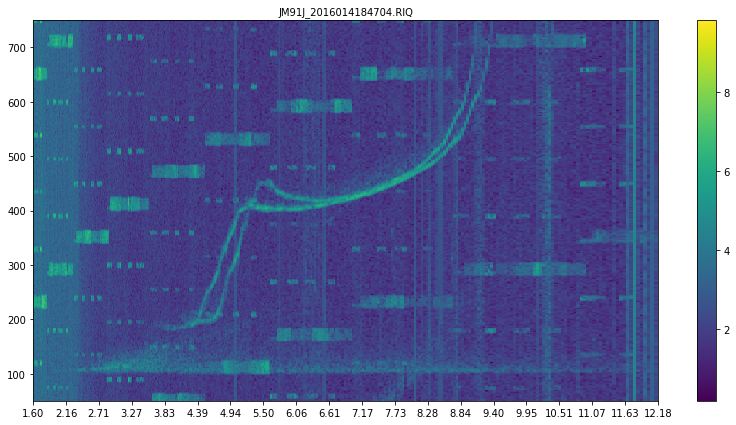

In [4]:
# Read File
# data type definition	
iq_t = np.dtype([('I','>i2'),('Q','>i2')])	
# header type definitions
sct_t = np.dtype([('magic','<u4'),('sounding_table_size','<u4'), ('pulse_table_size','<u4'), ('raw_data_size','<u4'), 
    ('struct_version','<f4'),('start_year','<u4'), ('start_daynumber','<u4'), ('start_month','<u4'), ('start_day','<u4'), 
    ('start_hour','<u4'), ('start_minute','<u4'), ('start_second','<u4'), ('start_epoch','<u4'), 
    ('readme','128<int8'), ('decimation_method','<u4'), ('decimation_threshold','<f4'), ('user','128<int8')])
station_t = np.dtype([('file_id','64<int8'), 
    ('ursi','8<int8'), ('rx_name','32<int8'), ('rx_latitude','<f4'), ('rx_longitude','<f4'), ('rx_altitude','<f4'), 
    ('rx_count','<u4'), ('rx_antenna_type','(32,32)<int8'), ('rx_position','(32,3)<f4'), ('rx_direction','(32,3)<f4'), 
    ('rx_height','32<f4'), ('rx_cable_length','32<f4'), ('frontend_atten','<f4'), ('tx_name','32<int8'), ('tx_latitude','<f4'), 
    ('tx_longitude','<f4'), ('tx_altitude','<f4'), ('tx_antenna_type','32<int8'), ('tx_vector','3<f4'), ('tx_height','<f4'), 
    ('tx_cable_length','<f4'), ('drive_band_count','<u4'), ('drive_band_bounds','(64,2)<f4'), ('drive_band_atten','64<f4'), 
    ('rf_control','<u4'), ('ref_type','32<int8'), ('clock_type','32<int8'), ('user','128<int8')])	
timing_t = np.dtype([ ('file_id','64<int8'), 
    ('pri','<f4'), ('pri_count','<u4'), ('ionogram_count','<u4'), ('holdoff','<f4'), ('range_gate_offset','<f4'), 
    ('gate_count','<u4'), ('gate_start','<f4'), ('gate_end','<f4'), ('gate_step','<f4'), ('data_start','<f4'), ('data_width','<f4'), 
    ('data_baud_count','<u4'), ('data_wave_file','64<int8'), ('data_baud','(1024,2)<f4'), ('data_pairs','<u4'), ('cal_start','<f4'), 
    ('cal_width','<f4'), ('cal_baud_count','<u4'), ('cal_wave_file','64<int8'), ('cal_baud','(1024,2)<f4'), ('cal_pairs','<u4'), 
    ('user','128<int8')])
frequency_t = np.dtype([('file_id','64<int8'), 
    ('base_start','<f4'), ('base_end','<f4'), ('base_steps','<u4'), ('tune_type','<u4'), 
    ('base_table','8192<f4'), ('linear_step','<f4'), ('log_step','<f4'), ('freq_table_id','64<int8'), ('tune_steps','<u4'), 
    ('pulse_count','<u4'), ('pulse_pattern','256<u4'), ('pulse_offset','<f4'), ('ramp_steps','<u4'), 
    ('ramp_repeats','<u4'), ('drive_table','8192<f4'), ('user','128<int8')])
receiver_t = np.dtype([('file_id','64<int8'), 
    ('rx_chan','<u4'), ('rx_map','16<u4'), ('word_format','<u4'), ('cic2_dec','<u4'), ('cic2_interp','<u4'), 
    ('cic2_scale','<u4'), ('cic5_dec','<u4'), ('cic5_scale','<u4'), ('rcf_type','32<int8'), ('rcf_dec','<u4'), ('rcf_taps','<u4'), 
    ('coefficients','160<u4'), ('analog_delay','<f4'), ('user','128<int8')])
exciter_t = np.dtype([('file_id','64<int8'), 
    ('cic_scale','<u4'), ('cic2_dec','<u4'), ('cic2_interp','<u4'), ('cic5_interp','<u4'), 
    ('rcf_type','32<int8'), ('rcf_taps','<u4'), ('rcf_taps_phase','<u4'), ('coefficients','256<u4'), ('analog_delay','<f4'), 
    ('user','128<int8')])
monitor_t = np.dtype([
    ('balun_currents','8<u4'), ('balun_status','8<u4'), ('front_end_status','8<u4'), ('receiver_status','8<u4'), 
    ('exciter_status','2<u4'), ('user','512<int8')])
pct_t = np.dtype([
    ('record_id','<u4'), ('pri_ut','<f8'), ('pri_time_offset','<f8'), ('base_id','<u4'), ('pulse_id','<u4'), ('step_id','<u4'), 
    ('repeat_id','<u4'), ('loop_id','<u4'), ('frequency','<f4'), ('nco_tune_word','<u4'), ('drive_attenuation','<f4'), 
    ('pa_flags','<u4'), ('pa_forward_power','<f4'), ('pa_reflected_power','<f4'), ('pa_vswr','<f4'), ('pa_temperature','<f4'), 
    ('proc_range_count','<u4'), ('proc_noise_level','<f4'), ('user','64<int8')])


import glob
import bz2
from IPython import display

print("Specify your path such as /raid/VIPIR/vipir2016/014/raw")
print("Hit enter to use default path")
foldername = raw_input("Please enter the path")
if foldername == "":
    foldername = "/raid/VIPIR/vipir2016/014/raw"
#filesname='*2018228*RIQ.bz2' # format JM91J_dddhhmmss.RIQ.bz2 
#filesname='*2018228*RIQ' # format JM91J_dddhhmmss.RIQ
#adjust regexp above to choose ionosondes to plot
#filesname='*.RIQ.bz2'
filesname='*.RIQ'
datafiles = glob.glob1(foldername+'/',filesname) 
datafiles.sort()
default_filename = datafiles[int(len(datafiles)/2)]
print(datafiles[0] + " ... " + default_filename + " ... " + datafiles[-1])
print("Please Specify the file you want")
print("Default is %s" %default_filename)
filename = raw_input("")
if filename == "":
    filename = default_filename
rcParams.update({'xtick.labelsize':10,'ytick.labelsize':10})
pngno=0

fullname = foldername+'/'+filename
print(fullname)
fid=open(fullname,'rb')  # opening *.RIQ files
#fid=bz2.BZ2File(fullname,'rb') # opening *.RIQ.bz2 files

print(fid)

# read common headers
# read with np.fromfile *.RIQ files: sct = np.fromfile(fid,sct_t,1) 
sct = np.fromfile(fid,sct_t,1)
station = np.fromfile(fid,station_t,1)
timing = np.fromfile(fid,timing_t,1)
frequency = np.fromfile(fid,frequency_t,1)
receiver = np.fromfile(fid,receiver_t,1)
exciter = np.fromfile(fid,exciter_t,1)
monitor = np.fromfile(fid,monitor_t,1)
'''
# read with frombuffer *.RIQ.bz2 files:  
sct = frombuffer(fid.read(sct_t.itemsize),sct_t,1)   
station = frombuffer(fid.read(station_t.itemsize),station_t,1)
timing = frombuffer(fid.read(timing_t.itemsize),timing_t,1)
frequency = frombuffer(fid.read(frequency_t.itemsize),frequency_t,1)
receiver = frombuffer(fid.read(receiver_t.itemsize),receiver_t,1)
exciter = frombuffer(fid.read(exciter_t.itemsize),exciter_t,1)
monitor = frombuffer(fid.read(monitor_t.itemsize),monitor_t,1)
'''
# extract useful header info
rx_chan = receiver['rx_chan'][0]   # 8
base_steps = frequency['base_steps'][0]   # variable
pulse_count = frequency['pulse_count'][0]   # pulses per base_step
ramp_repeats = frequency['ramp_repeats'][0]   # 
ionogram_count = timing['ionogram_count'][0]
gate_count=timing['gate_count'][0]   # hts sampled
gate_start = timing['gate_start'][0]   # in us
gate_step = timing['gate_step'][0]   # in us
range_gate_offset = timing['range_gate_offset'][0]   # to be subtracted from gate_start 
h0 = (gate_start-range_gate_offset)*0.15   # in km 
dh = gate_step*0.15
hlast = h0+dh*gate_count
hts = np.arange(h0,hlast,dh)   # define height grid
freqs = np.zeros(base_steps)   # initiate freq grid
ionograms = np.zeros([rx_chan,gate_count,base_steps])   # initiate ionogram buffer
tx_count = base_steps*ramp_repeats*pulse_count*ionogram_count   # total number of tx'ed pulses per ionogram

for i in range(tx_count):   # frequency sweep loop
    pct = np.frombuffer(fid.read(pct_t.itemsize),pct_t,1)   # read frequency header
    base_id = pct['base_id'][0]
    pulse_id = pct['pulse_id'][0]
    step_id = pct['step_id'][0]
    repeat_id = pct['repeat_id'][0]
    iq = np.frombuffer(fid.read(iq_t.itemsize*rx_chan*gate_count),iq_t,rx_chan*gate_count)   # read raw I and Q returns per pulse
    volt = iq['I']+1j*iq['Q']   # form complex voltage I+jQ profile
    volt = volt.reshape(gate_count,rx_chan)
    power = abs(volt)**2

    voltOX=volt
    voltOX[:,0]=volt[:,0]+volt[:,1]
    voltOX[:,1]=volt[:,0]-volt[:,1]
    powerOX = abs(voltOX)**2   # square detection

    if i%20>3:
        ionograms[0,:,base_id-1] += power[:,0]   # accumulated ionograms
        ionograms[1,:,base_id-1] += power[:,1]
        ionograms[2,:,base_id-1] += powerOX[:,0]   # accumulated ionograms
        ionograms[3,:,base_id-1] += powerOX[:,1]

    freqs[base_id-1] = pct['frequency'][0]   # fill frequency grid

freqs = freqs/1000.
fid.close()   # vipir raw data file closed 


'''
subplot(2,2,1)
im = plt.pcolormesh(freqs,hts,log10(ionograms[0,:,:]))
im.set_clim(0.2,9.8)
im.axes.set_xlim(2,12); im.axes.set_ylim(50,750); 
im.axes.set_title(filename); im.axes.title.set_fontsize(10.0)
colorbar()

subplot(2,2,2)
im = pcolormesh(freqs,hts,log10(ionograms[1,:,:]))
im.set_clim(0.2,9.8)
im.axes.set_xlim(2,12); im.axes.set_ylim(50,750); 
im.axes.set_title(filename); im.axes.title.set_fontsize(10.0)
colorbar()

subplot(2,2,3)
im = pcolormesh(freqs,hts,log10(ionograms[2,:,:]))
im.set_clim(0.2,9.8)
im.axes.set_xlim(2,12); im.axes.set_ylim(50,750); 
im.axes.set_title(filename); im.axes.title.set_fontsize(10.0)
colorbar()

subplot(2,2,4)
im = pcolormesh(freqs,hts,log10(ionograms[3,:,:]))
im.set_clim(0.2,9.8)
im.axes.set_xlim(2,12); im.axes.set_ylim(50,750); 
im.axes.set_title(filename); im.axes.title.set_fontsize(10.0)
colorbar()
'''

plt.figure(figsize = (14, 7))
im = plt.pcolormesh(freqs,hts,np.log10(ionograms[0,:,:]))
im.set_clim(0.2,9.8)
im.axes.set_xlim(2,12); im.axes.set_ylim(50,750); 
plt.xticks(np.linspace(freqs.min(), freqs.max(), 20))
im.axes.set_title(filename); im.axes.title.set_fontsize(10.0)
plt.colorbar()
plt.show()

<Figure size 1440x720 with 0 Axes>

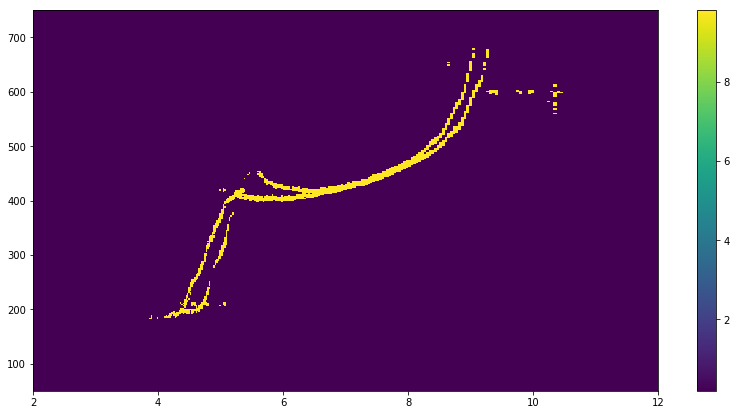

In [5]:
data_final = whole_clean_procedure()

plt.figure(figsize=(14, 7))
im = plt.pcolormesh(freqs,hts,data_final)
im.set_clim(0.2,9.8)
im.axes.set_xlim(2,12); im.axes.set_ylim(50,750); 
plt.colorbar()
plt.show(im)

In [24]:
# import OXmode from c
# using the following script to compile *.c file
# gcc -shared -o OXmode.so -fPIC OXmode.c -lm

clib = ctypes.cdll.LoadLibrary("./OXmode.so")
cOXmode = clib.OXmode

# cOXmode.restype = None
cOXmode.argtypes = [
    ndpointer(ctypes.c_double, flags="C_CONTIGUOUS"),
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_double,
    ctypes.c_double,
    ndpointer(ctypes.c_double, flags="C_CONTIGUOUS"), 
    ctypes.c_int,
    ndpointer(ctypes.c_double, flags="C_CONTIGUOUS"), 
    ctypes.c_int,
    ndpointer(ctypes.c_double, flags="C_CONTIGUOUS"),
    ndpointer(ctypes.c_double, flags="C_CONTIGUOUS"),
    ctypes.c_double
                   ]

def OXmode(fps):
    fcO = fps.max()
    fvsO = np.arange(41.0, np.ceil(40*fcO) + 1)/40.0
    vhsO = np.zeros(fvsO.shape)
    
    fe = 4.4/2/np.pi # electron gyro-frequency in MHz
    fcX = (np.sqrt(4*fcO*fcO + fe + fe) + fe)/2.0        # critical frequency in X-mode
    fvsX = np.arange(41.0, np.ceil(40*fcX) + 1)/40.0     # setting the frequencies to skim through
    vhsX = np.zeros(fvsX.shape)
    cOXmode(fps, len(fps), fcO, fcX, dz, fvsO, len(fvsO), fvsX, len(fvsX), vhsO, vhsX, fe)
    return fvsO, vhsO, fvsX, vhsX

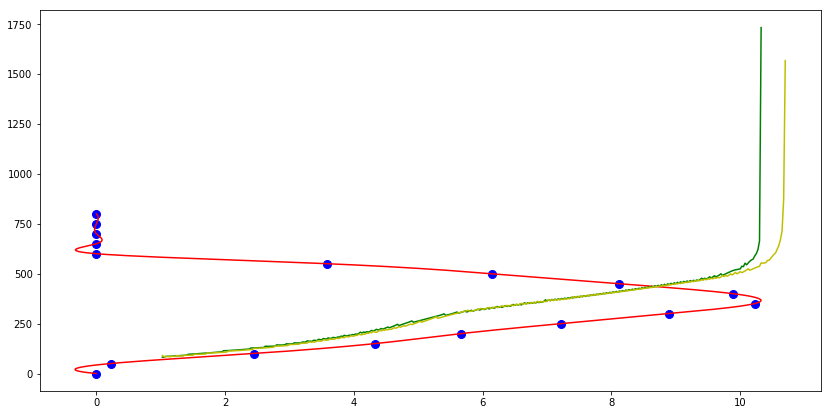

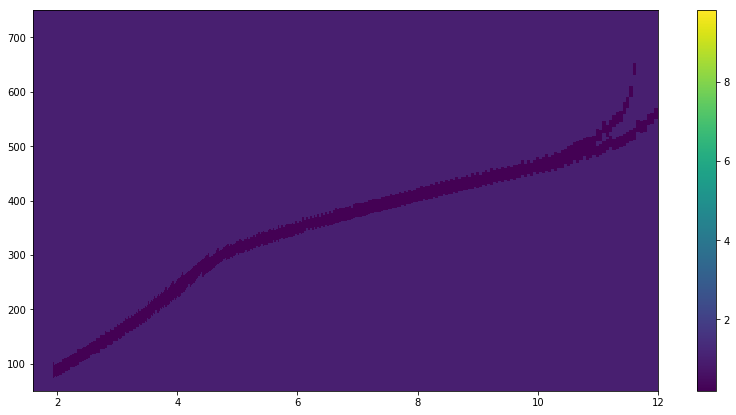

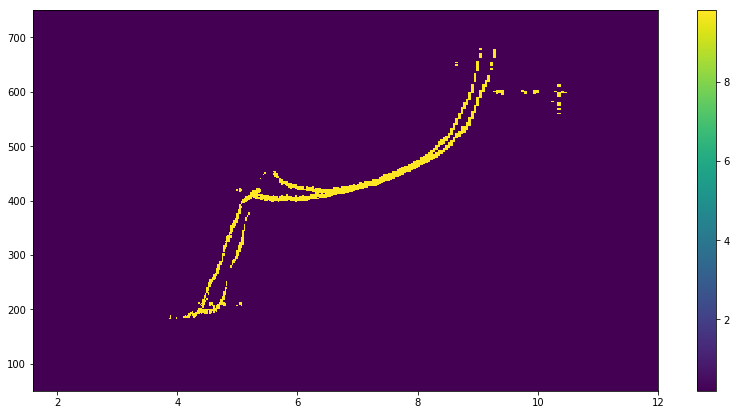

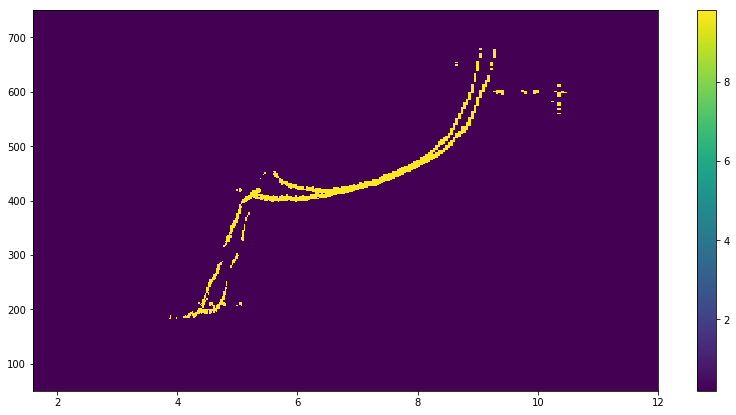

In [32]:
def masked_power(xvals, data_final, N, dz):
    spline = inter.InterpolatedUnivariateSpline(z,xvals)
    Z = np.arange(0,zmax+1,dz)
    fps=spline(Z)
    fvsO,vhsO,fvsX,vhsX = OXmode(fps)
    masked = np.multiply(data_final, create_mask(fvsO, fvsX, vhsO, vhsX, data_final, N))
    power = np.sum(masked)
    return power

def masked_fixed_xvals_power(a, xvals, s, data_final, N, dz):
    return masked_power(xvals + a*s, data_final, N, dz)

def J(xvals, data_final, N, dz):
    df = np.zeros(N)
    for i in range(0, N):
        xvals_updated = xvals.copy()
        xvals_updated[i] += dx
        df[i] = masked_power(xvals_updated, data_final, N, dz) - masked_power(xvals, data_final, N, dz)
    dfdx = df/dx
    return dfdx

N = 17
zmin = 0
zmax = 800
z = np.linspace(zmin,zmax,N)
xvals=np.array([0.,0.22222222,2.4444444,4.33333333,5.6666666,7.22222222,8.88888889,
       10.2222222,9.88888889,8.11111111,6.15,3.5875,0.,0.,0.,0.,0.])
spline = inter.InterpolatedUnivariateSpline(z,xvals)

dz = 0.5
dx = 0.01
Z = np.arange(0,zmax+1,dz)
fps=spline(Z)
fvsO,vhsO,fvsX,vhsX = OXmode(fps)

fig,axes = plt.subplots(1,1,figsize=(14,7),sharex=True)
ax1 = axes
l, = ax1.plot (xvals,z,color='b',linestyle='none',marker='o',markersize=8)
m, = ax1.plot (spline(Z), Z, 'r-', label='spline fp')

mO, = ax1.plot (fvsO, vhsO, 'g-', label='O-trace hv')
mX, = ax1.plot (fvsX, vhsX, 'y-', label='X-trace hv')

mask = create_mask(fvsO, fvsX, vhsO, vhsX, data_final, N)
plt.figure(figsize=(14, 7))
im = plt.pcolormesh(freqs,hts,mask)
im.set_clim(0.2,9.8)
im.axes.set_xlim(1.6,12); im.axes.set_ylim(50,750); 
plt.colorbar()
plt.show(im)

plt.figure(figsize=(14, 7))
im = plt.pcolormesh(freqs,hts,data_final)
im.set_clim(0.2,9.8)
im.axes.set_xlim(1.6,12); im.axes.set_ylim(50,750); 
plt.colorbar()
plt.show(im)

masked = np.multiply(data_final, mask)
plt.figure(figsize=(14, 7))
im = plt.pcolormesh(freqs,hts,masked)
im.set_clim(0.2,9.8)
im.axes.set_xlim(1.6,12); im.axes.set_ylim(50,750); 
plt.colorbar()
plt.show(im)

In [12]:
Z.shape

(1602,)

In [27]:
xvals_updated = xvals.copy()
xvals_updated[3] += dx

print(xvals)
print(xvals_updated)
print(masked_power(xvals_updated, data_final, N, dz))
print(masked_power(xvals, data_final, N, dz))

[ 0.          0.22222222  2.4444444   4.33333333  5.6666666   7.22222222
  8.88888889 10.2222222   9.88888889  8.11111111  6.15        3.5875
  0.          0.          0.          0.          0.        ]
[ 0.          0.22222222  2.4444444   4.34333333  5.6666666   7.22222222
  8.88888889 10.2222222   9.88888889  8.11111111  6.15        3.5875
  0.          0.          0.          0.          0.        ]
18960.0
19050.0


In [33]:
from numpy import linalg as la
import scipy.optimize as sopt
s = -J(xvals, data_final, N, dz)
sopt.minimize_scalar(masked_fixed_xvals_power, args = (xvals, s, data_final, N, dz), bounds = (-0.001, 0.001))

     fun: 13470.0
    nfev: 49
     nit: 45
 success: True
       x: 9.502829389256618e-05

In [52]:
s*0.001+xvals

array([ 0.        ,  0.22222222,  1.4444444 , 13.33333333, 14.6666666 ,
        8.22222222,  8.88888889, 10.2222222 ,  9.88888889,  8.11111111,
        6.15      ,  3.5875    ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [53]:
masked_power(xvals+0.001*s, data_final, N)

19750.0

In [54]:
masked_fixed_xvals_power(0.00, xvals, s, data_final, N)

19050.0

In [66]:
a = np.linspace(-0.001, 0.001, 100);

y = np.zeros(a.shape)
for i in range(0, len(a)):
    y[i] = masked_fixed_xvals_power(a[i], xvals, s, data_final, N)

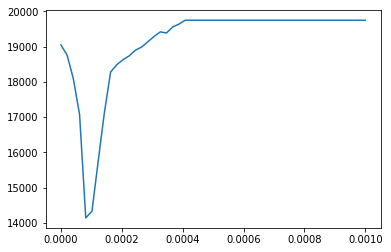

In [64]:
plt.plot(a, y)

In [57]:
def opt(xvals):
    s = -J(xvals, data_final, N, dz)
    while abs(s) < 0.001:
        alpha = sopt.minimize_scalar(masked_fixed_xvals_power, args = (xvals, s, data_final, N, dz), bounds = (-0.001, 0.001))["x"]
        xvals = s*alpha + xvals
        s = -J(xvals, data_final, N, dz)
        

19750.0

In [19]:

J(xvals, data_final, N)

array([    0.,     0.,  1000., -2000.,  2000., -3000., -6000., -1000.,
       -2000.,  2000.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.])

In [20]:
minimize?

In [35]:
result = minimize(masked_power, xvals, args = (data_final, N, dz), jac = J)

In [36]:
result

      fun: 13690.0
 hess_inv: array([[ 9.61481106e-01,  3.53281959e-02,  1.54842077e-01,
        -2.96573720e-01, -1.52263583e-01,  1.93258683e-01,
        -1.66960793e-02, -1.27627921e-02, -7.70377879e-02,
        -3.03268432e-02, -3.85188939e-02, -3.85188939e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 3.53281959e-02,  9.49200523e-01, -1.36543191e-01,
         9.96848757e-02, -5.82849050e-02,  1.84619810e-03,
         7.22549933e-02, -6.18851238e-02,  7.06563918e-02,
         2.90954066e-02,  3.53281959e-02,  3.53281959e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.54842077e-01, -1.36543191e-01,  7.02388442e-01,
        -3.63228258e-01, -4.33265194e-01,  2.75379699e-01,
         3.76775094e-01,  7.31955446e-02,  3.09684155e-01,
         9.64070932e-02,  1.54842077e-01,  1.54842077e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,

In [37]:
result["x"]

array([2.33071685e-06, 2.26194721e-01, 2.35892548e+00, 5.11483492e+00,
       6.44814954e+00, 7.25204689e+00, 8.87298490e+00, 1.02381215e+01,
       9.88889355e+00, 8.11111344e+00, 6.15000233e+00, 3.58750233e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [38]:
xvals_updated = result["x"]
print(xvals)
print(xvals_updated)

[ 0.          0.22222222  2.4444444   4.33333333  5.6666666   7.22222222
  8.88888889 10.2222222   9.88888889  8.11111111  6.15        3.5875
  0.          0.          0.          0.          0.        ]
[2.33071685e-06 2.26194721e-01 2.35892548e+00 5.11483492e+00
 6.44814954e+00 7.25204689e+00 8.87298490e+00 1.02381215e+01
 9.88889355e+00 8.11111344e+00 6.15000233e+00 3.58750233e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


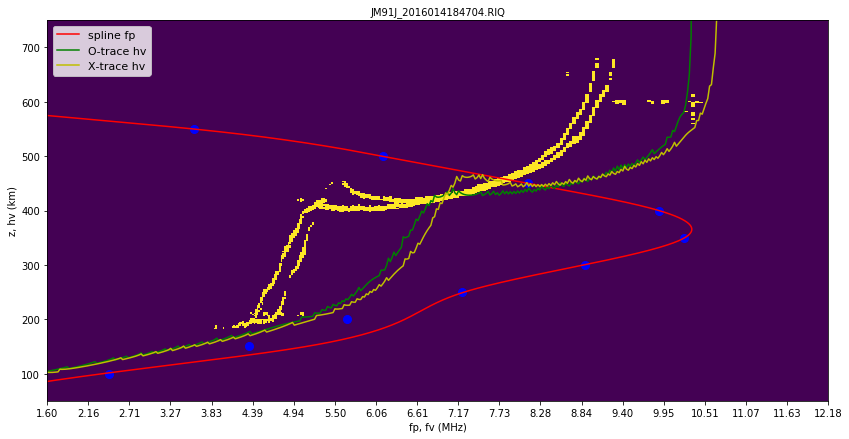

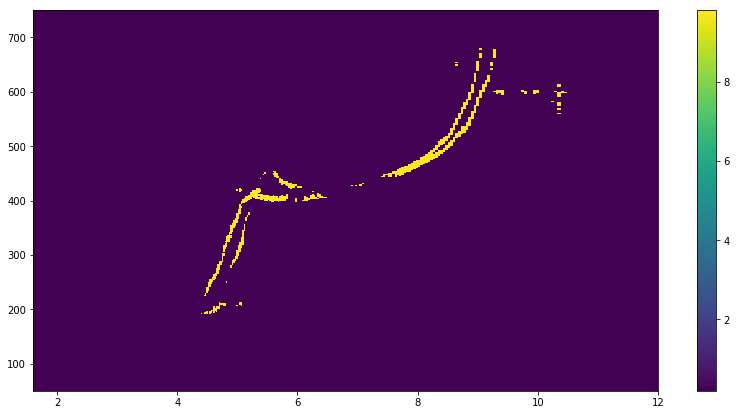

In [39]:
spline = inter.InterpolatedUnivariateSpline (z,xvals_updated)

#set up a plot
fig,axes = plt.subplots(1,1,figsize=(14, 7),sharex=True)
ax1 = axes

# height grid
Z = np.arange(0,zmax+1,dz)
fps=spline(Z)
#ax1.plot (fp(Z),Z, 'k--', label='original')
l, = ax1.plot (xvals,z,color='b',linestyle='none',marker='o',markersize=8)
m, = ax1.plot (spline(Z), Z, 'r-', label='spline fp')

fvsO,vhsO,fvsX,vhsX=OXmode(fps)
mO, = ax1.plot (fvsO, vhsO, 'g-', label='O-trace hv')
mX, = ax1.plot (fvsX, vhsX, 'y-', label='X-trace hv')

# def update(val):
#     # update curve
#     for i in np.arange(N):
#         xvals[i] = sliders[i].val
#     l.set_xdata(xvals)
#     spline = inter.InterpolatedUnivariateSpline (z,xvals)
#     fps=spline(Z)
#     m.set_xdata(fps)
#     fvsO,vhsO,fvsX,vhsX=OXmode(fps)
#     mO.set_xdata(fvsO)
#     mO.set_ydata(vhsO)
#     mX.set_xdata(fvsX)
#     mX.set_ydata(vhsX)
#     fig.canvas.draw_idle()

ax1.set_yscale('linear')
ax1.set_xlim(0,12)
ax1.set_ylim(0,zmax)
ax1.set_xlabel('fp, fv (MHz)')
ax1.set_ylabel('z, hv (km)')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=2,prop={'size':11})



# Used to generate single image
im = plt.pcolormesh(freqs,hts,data_final)
im.set_clim(0.2,9.8)
im.axes.set_xlim(2,12); im.axes.set_ylim(50,750); 
plt.xticks(np.linspace(freqs.min(), freqs.max(), 20))
im.axes.set_title(filename); im.axes.title.set_fontsize(10.0)
plt.show(im)

fvsO,vhsO,fvsX,vhsX = OXmode(fps)
masked = np.multiply(data_final, create_mask(fvsO, fvsX, vhsO, vhsX, data_final, 9))
plt.figure(figsize=(14, 7))
im = plt.pcolormesh(freqs,hts,masked)
im.set_clim(0.2,9.8)
im.axes.set_xlim(1.6,12); im.axes.set_ylim(50,750); 
plt.colorbar()
plt.show(im)